<div>
    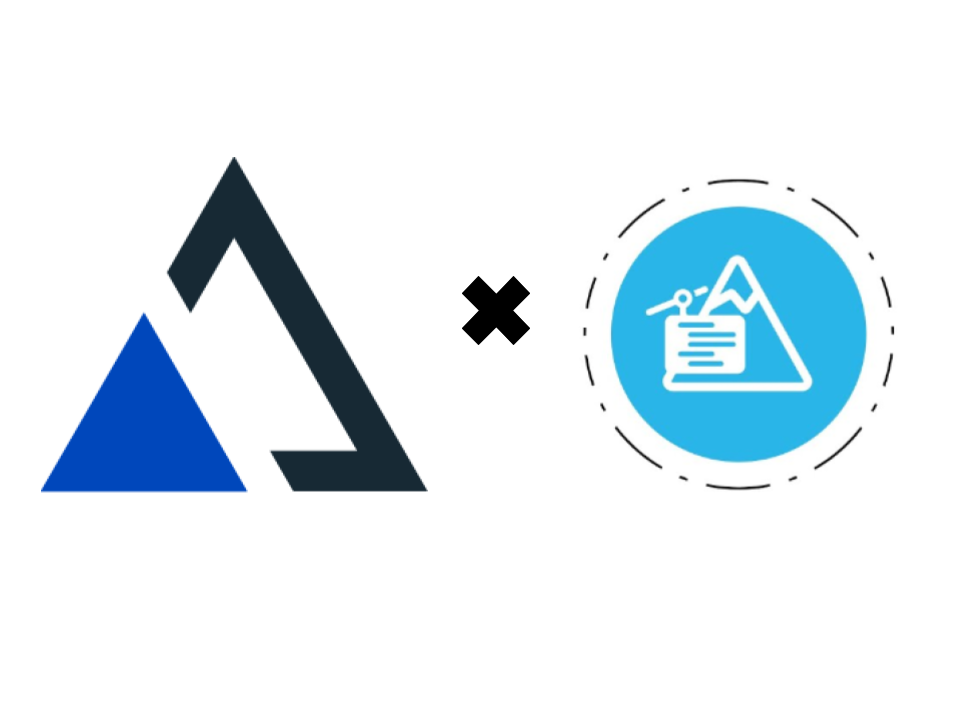
</div>

<h1 style="text-align:center;font-weight: bold;"><font color = "0047BB" size = "10px">Simple AI-Link x Snowpark</font></h1>
<p style = "text-align:center">
<font color = "0047BB">In this demo we will walk through the most basic implementation of Snowpark and AI-Link.</font>

</p>    <br>
As a quick refresher, Snowpark is a connection to Snowflake that allows developers to:
<ol style="list-style-type: lower-alpha"><li><b>Deploy and execute native Python, Java, and Scala code in Snowflake</b></li>
    <li><b>Edit data without moving it</b></li>
    <li><b>Schedule regularly occurring processes/analysis to automate insights</b></li></ol>
    
To see the capabilities of Snowpark in a straightforward way, we will be using the <a href = "https://www.kaggle.com/datasets/uciml/iris">Iris Dataset</a>, a small dataset of flower petal measurements, and applying a linear regression model to two columns -- Average Petal Length and Petal Width -- to see if there is a correlation between the two. Note, however, that the use cases of AI-Link and Snowpark exceed what you will see in this demo. 

<b>Purpose:</b> With this correlation we can <font style = "text-decoration: underline">create a predictive model to provide a baseline for anthologists</font> to use when studying how different factors make the petals deviate from the normal average length for an arbitrary flower's corresponding petal width.

<h3><font color = "0047BB">Method:</font></h3>
<ol><b><font color = "0047BB"><li>Get data from AtScale with AI-Link</li>
    <li>Confirm Correlation and Model Utility</li>
    <li>Push Data to Snowflake</li>
    <li>Automate Line of Best Fit Refitting with Snowpark</li></font></b>

<div>
    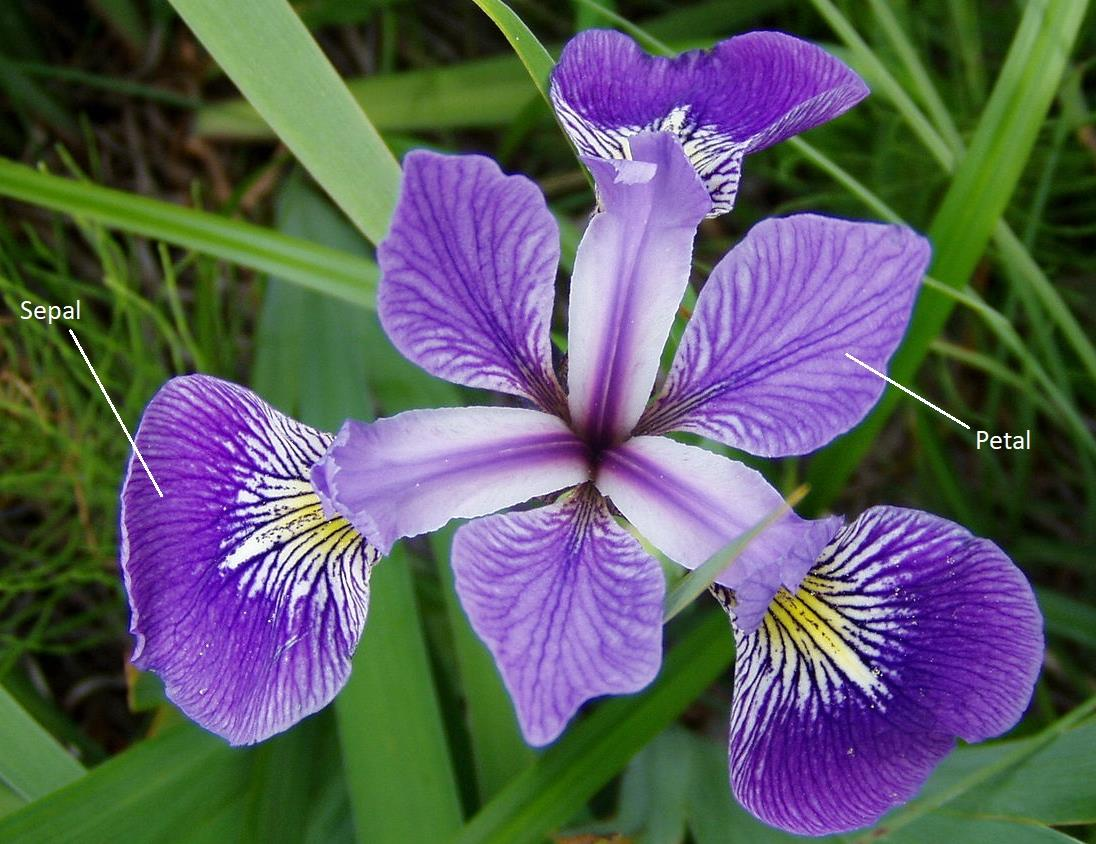

### Prerequisites
<ol><li><b>AtScale Python API</b> installed as detailed <a href = "https://github.com/AtScaleInc/python-api"> on our GitHub </a></li>
    <li>You have <b>Snowpark <a href = "https://docs.snowflake.com/en/developer-guide/snowpark/python/setup">installed </a></b></li>
    <li>You have <b>created an environment</b> with the appropriate <a href = "https://drive.google.com/file/d/1vs-CEc3K42n1WDGBmfqwZxyT0tLTi89d/view?usp=drive_link">dependencies for Snowpark </a></li>
    <li>You have already created a <b>semantic model</b> in AtScale</li>
    <li>You have configured your <b>Snowflake and AtScale permissions</b> into a local JSON</li>
    <li>You are using Python <b>3.8</b></li>
    </ol>

## Connect to AtScale

In [1]:
from atscale.client import Client
from atscale.data_model import DataModel
from atscale.project import Project
from atscale.db.connections import Snowflake

from snowflake.snowpark.dataframe import col
from snowflake.snowpark import Session
from snowflake.snowpark.functions import sproc

import json
import pkg_resources
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

<b>Our Permissions file is structured like so:<b>
    
<code>{
"atscale_server": atscale instance url,
"atscale_organization": org,
"atscale_username": username,
"atscale_password": password,
"atscale_project": name of the project,
"snowflake_account": snowflake account ID,
"snowflake_username": snowflake username,
"snowflake_password": snowflake password,
"snowflake_role": snowflake role,
"snowflake_warehouse": snowflake warehouse name,
"snowflake_database": database within that warehouse,
"snowflake_schema": schema within that database
}</code>

In [2]:
with open("/permissions") as file:
    permissions = json.load(file)

In [3]:
client = Client(
    server = permissions["atscale_server"],
    organization = permissions["atscale_organization"],
    username = permissions["atscale_username"],
    password = permissions["atscale_password"]
)

In [ ]:
client.connect()

In [ ]:
project = client.select_project(name_contains=permissions["atscale_project"])

In [ ]:
dm = project.select_data_model(name_contains="IrisDataCube")

In [ ]:
connection_parameters = {
    "account": permissions["snowflake_account"],
    "user": permissions["snowflake_username"],
    "password": permissions["snowflake_password"],
    "role": permissions["snowflake_role"],
    "warehouse": permissions["snowflake_warehouse"],
    "database": permissions["snowflake_database"],
    "schema": permissions["snowflake_schema"]
}

In [ ]:
session = Session.builder.configs(connection_parameters).create()

<br><br><p style = "text-align: center"><i><font color = "#092755">If you are ever curious if a cell is Snowpark code, AtScale code, a combination of both, or neither, simply go to View -> Cell Tool Bar -> Tags to see the tags attached to each cell which will explain the type of code.</font></i></p><br><br>

<h1 style="text-align:center;font-weight: bold;"><font color = "0077A7" size = "6px">Make Snowpark Dataframe with AtScale Data</font></h1>

Utilize AI-Link's <code>get_database_query()</code> to get the SQL query that will fetch the Iris dataset from Snowflake when fed into Snowpark's <code>session.sql()</code>  

<h5><font color = "0077A7">1) Check what features you have to work with</font></h5>

In [ ]:
# Get numeric features 
num_features = dm.get_all_numeric_feature_names()
num_features

In [ ]:
# Get categorical features 
cat_features = dm.get_all_categorical_feature_names()
cat_features

<h5><font color = "0077A7">2) Easily select the ones you want</font></h5>

In [ ]:
# Generate appropriate SQL query
query = dm.get_database_query(feature_list = [num_features[0], cat_features[0]])
print(query)

<h5><font color = "0077A7">3) Feed autogenerated query into Snowpark Dataframe</font></h5>

In [ ]:
snow_df = session.sql(query)
snow_df.show(3)

Now that we have our data from Snowflake, we can do our feature engineering here, however since we already have the measures we need, we will skip that step. Instead <b>let's see whether there is a correlation</b> using a simple scatter plot.

<font color = "#cc0000">DISCLAIMER:<b> This plotting library does not work with Snowpark dataframes</b> as they are lazily evaluated opposed to pandas which are eagerly evaluated, so we have to cast to a pandas dataframe. However, with the new release of <b>Snowpark ML</b>, you can do the modeling we do later with Snowpark dataframes.</font>

In [ ]:
petals = snow_df.to_pandas()

In [ ]:
# Create scatter plot
plt.scatter(petals['Petal_W_Idth_Cm Level'], petals['m_PETAL_LENGTH_CM_avg'])

In [ ]:
# Fit a line to data trend 
reg = LinearRegression().fit(petals[['Petal_W_Idth_Cm Level']],petals['m_PETAL_LENGTH_CM_avg'] )

# Plot
plt.scatter(petals['Petal_W_Idth_Cm Level'], petals['m_PETAL_LENGTH_CM_avg'])
plt.plot(petals['Petal_W_Idth_Cm Level'], reg.predict(petals[['Petal_W_Idth_Cm Level']]))

<p><b>Discovery:</b> It looks like there is a <font style = "text-decoration: underline">linear relationship between Average Petal Length and Petal Width</font>. Let's continue to pursue this by automating the line fitting process to happen on a schedule as we add more data.</p>

<h1 style="text-align:center;font-weight: bold;"><font color = "0077A7" size = "6px;" >Pushing and Pulling Data from Snowflake</font></h1><br>
As a sidebar, after any feature engineering, we can push the changes to Snowflake with a few simple steps.  

The same is true for getting data from Snowflake. <font style = "text-decoration: underline">Earlier we used an AtScale generated SQL statement to get the data</font> (which is useful if the data is in different fact tables), but since our data is now all in one table, we can reference the table by its name to get the data.

<h4>Push data to Snowflake

In [ ]:
# Make columns capital because Snowflake will automatically do it later, making it hard to reference
cols = petals.columns 
petals = petals.rename(columns = {cols[0]: 'Petal_W_Idth_Cm Level'.upper(), cols[1]: 'm_PETAL_LENGTH_CM_avg'.upper()})

In [ ]:
table_name = 'PETALS_DEMO'
session.write_pandas(petals, table_name, auto_create_table=True, overwrite=True)

<h4>Pull data from Snowflake

In [ ]:
snow_data = session.table(table_name)

In [ ]:
snow_data.show(3)

<h1 style="text-align:center;font-weight: bold;"><font color = "0077A7" size = "6px;">Make Stored Procedure</font></h1></br>
We will now define a reccuring user defined function (UDF) -- a Stored Procedure -- to <b>recalculate the line of best fit</b> for our scatter chart once a month to incorporate new values.

<h3>Preparation

In [ ]:
# Write packages to file for use in Stored Procedure
env = dict(tuple(str(ws).split()) for ws in pkg_resources.working_set)

sp_udf_packages = ['snowflake-snowpark-python', 'pandas', 'scikit-learn', 'matplotlib']
packages_version = dict((k , env[k]) for k in sp_udf_packages if k in env)

with open('packages_version.json', 'w') as outfile:
    outfile.write(json.dumps(packages_version))

In [ ]:
with open('packages_version.json', 'r') as infile:
    json.load(infile)

We <b>create a "Snowpark Stage"</b> where we can register our Stored Procedure

In [ ]:
session.sql('CREATE STAGE IF NOT EXISTS mini_stage').collect()

### Define

In [ ]:
def lin_reg_refit(session: Session, dataframe: str, x: str, y: str) -> str:
    petals = session.table(dataframe).to_pandas()
    
    reg = LinearRegression().fit(petals[[x]],petals[y] )
    fit_arr = reg.predict(petals[[x]])
    petals['PREDICTED_VALUE'] = fit_arr
    session.write_pandas(petals, dataframe, auto_create_table=True, overwrite=True)
    
    return (dataframe + " has been refit!")

### Register

In [ ]:
%%time
lin_reg_refit = session.sproc.register(
                                func=lin_reg_refit, 
                                name='lg_refit', 
                                is_permanent=True, 
                                replace=True,
                                stage_location='@mini_stage',
                                packages=[f'snowflake-snowpark-python=={packages_version["snowflake-snowpark-python"]}'
                                          ,f'matplotlib=={packages_version["matplotlib"]}'
                                          ,f'scikit-learn=={packages_version["scikit-learn"]}'])

### Call

In [ ]:
%%time
lin_reg_refit(session, table_name, 'M_PETAL_LENGTH_CM_AVG', 'PETAL_W_IDTH_CM LEVEL')

In [ ]:
# Pull the changed dataframe from Snowflake
snow_edited = session.table(table_name)
snow_edited.show(3)

In [ ]:
# Change to pandas df to be able to use plt library
petals_edited = snow_edited.to_pandas() 

x='M_PETAL_LENGTH_CM_AVG'
y='PETAL_W_IDTH_CM LEVEL'

In [ ]:
# Plot
plt.scatter(petals_edited[x], petals_edited[y])
plt.plot(petals_edited[x], petals_edited['PREDICTED_VALUE'])

### Schedule
Without creating a task, the Stored Procedure we created is essentially just another UDF that has to be manually called. In order to show how to regularly update the <code>PREDICTED_VALUE</code> column of our Snowflake table, we will issue SQL queries to:
<ol><li> Create a task</li>
    <li> Start the task </li>
    <li> Pause the task </li>
    <li> See all tasks </li>
    <li> Delete the task </li></ol>

In [ ]:
#Ensure you have the appropriate permissions (Execute Task)
privileges = session.sql('SHOW GRANTS to ROLE AI_LINK').collect()
task_priv = 'EXECUTE TASK' in str(privileges)

print(permissions["snowflake_role"],"has task privilege:", task_priv)

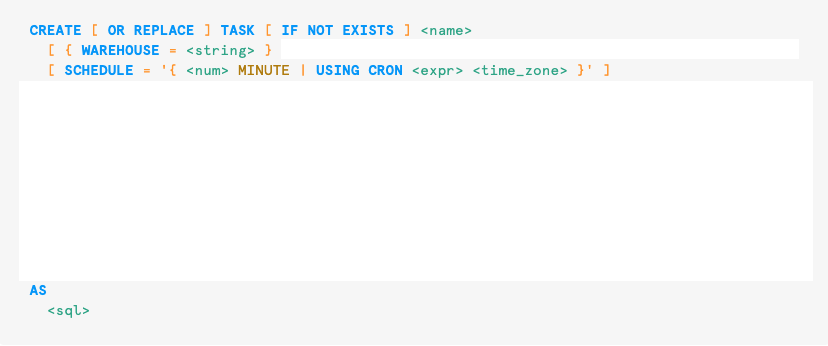
<p style = "text-align: center">This is the <b>minimum requirement formula</b>, and what we will be using today</p>

In [ ]:
# Create task
sql = "CREATE OR REPLACE TASK lg_fitting " + \
      "WAREHOUSE = 'AI_LINK_XSMALL' " + \
      "SCHEDULE = 'USING CRON 0 15 10 * * UTC' " + \
      "AS CALL lg_fitting('petals_demo', 'PETAL_W_IDTH_CM LEVEL', 'M_PETAL_LENGTH_CM_AVG');"
session.sql(sql).show()

In [ ]:
# Unsuspend task
session.sql('ALTER TASK lg_fitting RESUME;').show()

In [ ]:
# Suspend task
session.sql('ALTER TASK lg_fitting SUSPEND;').show()

<h2><font color = "#0077A7">Results</font></h4>

In [ ]:
# See tasks
session.sql('SHOW TASKS').select(col('"name"'),col('"state"'),col('"created_on"'), col('"schedule"')).to_pandas()

In [ ]:
# Delete task
session.sql('DROP TASK IF EXISTS LG_FITTING').show()

<br><br><br><br><br>

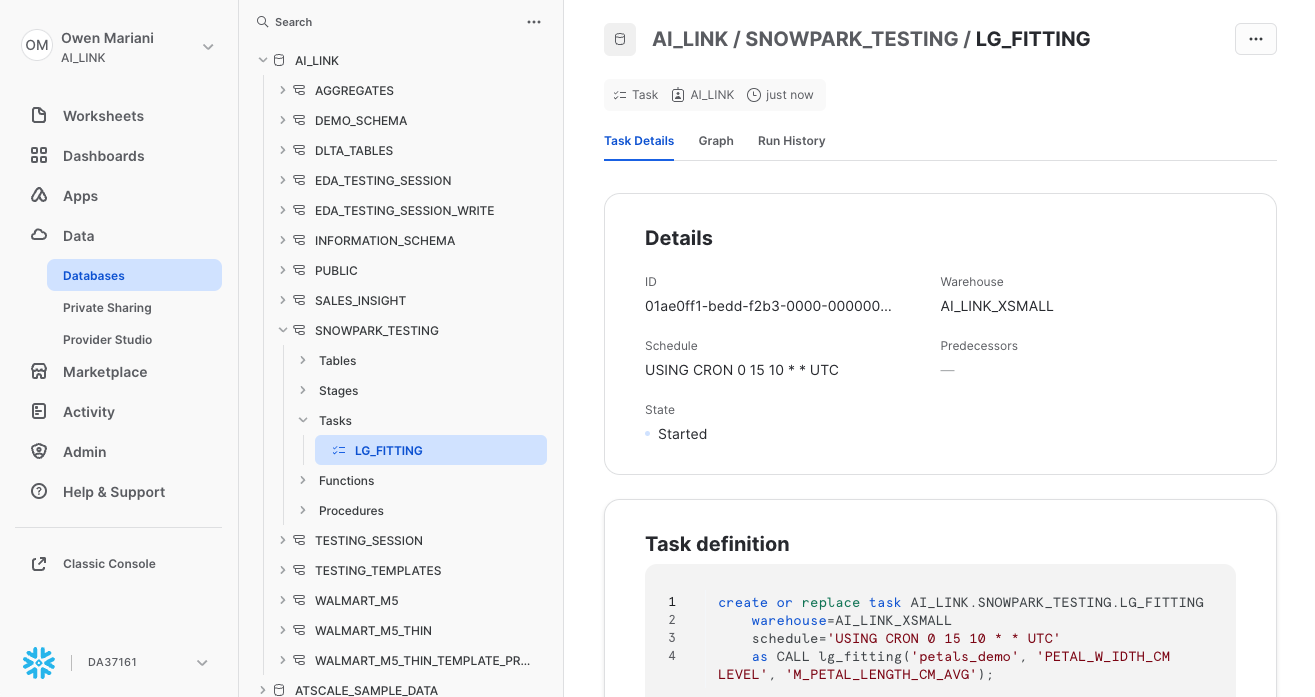
<p style = "text-align: center">You can also view your tasks in your databases in the <b>Data</b> tab</p>

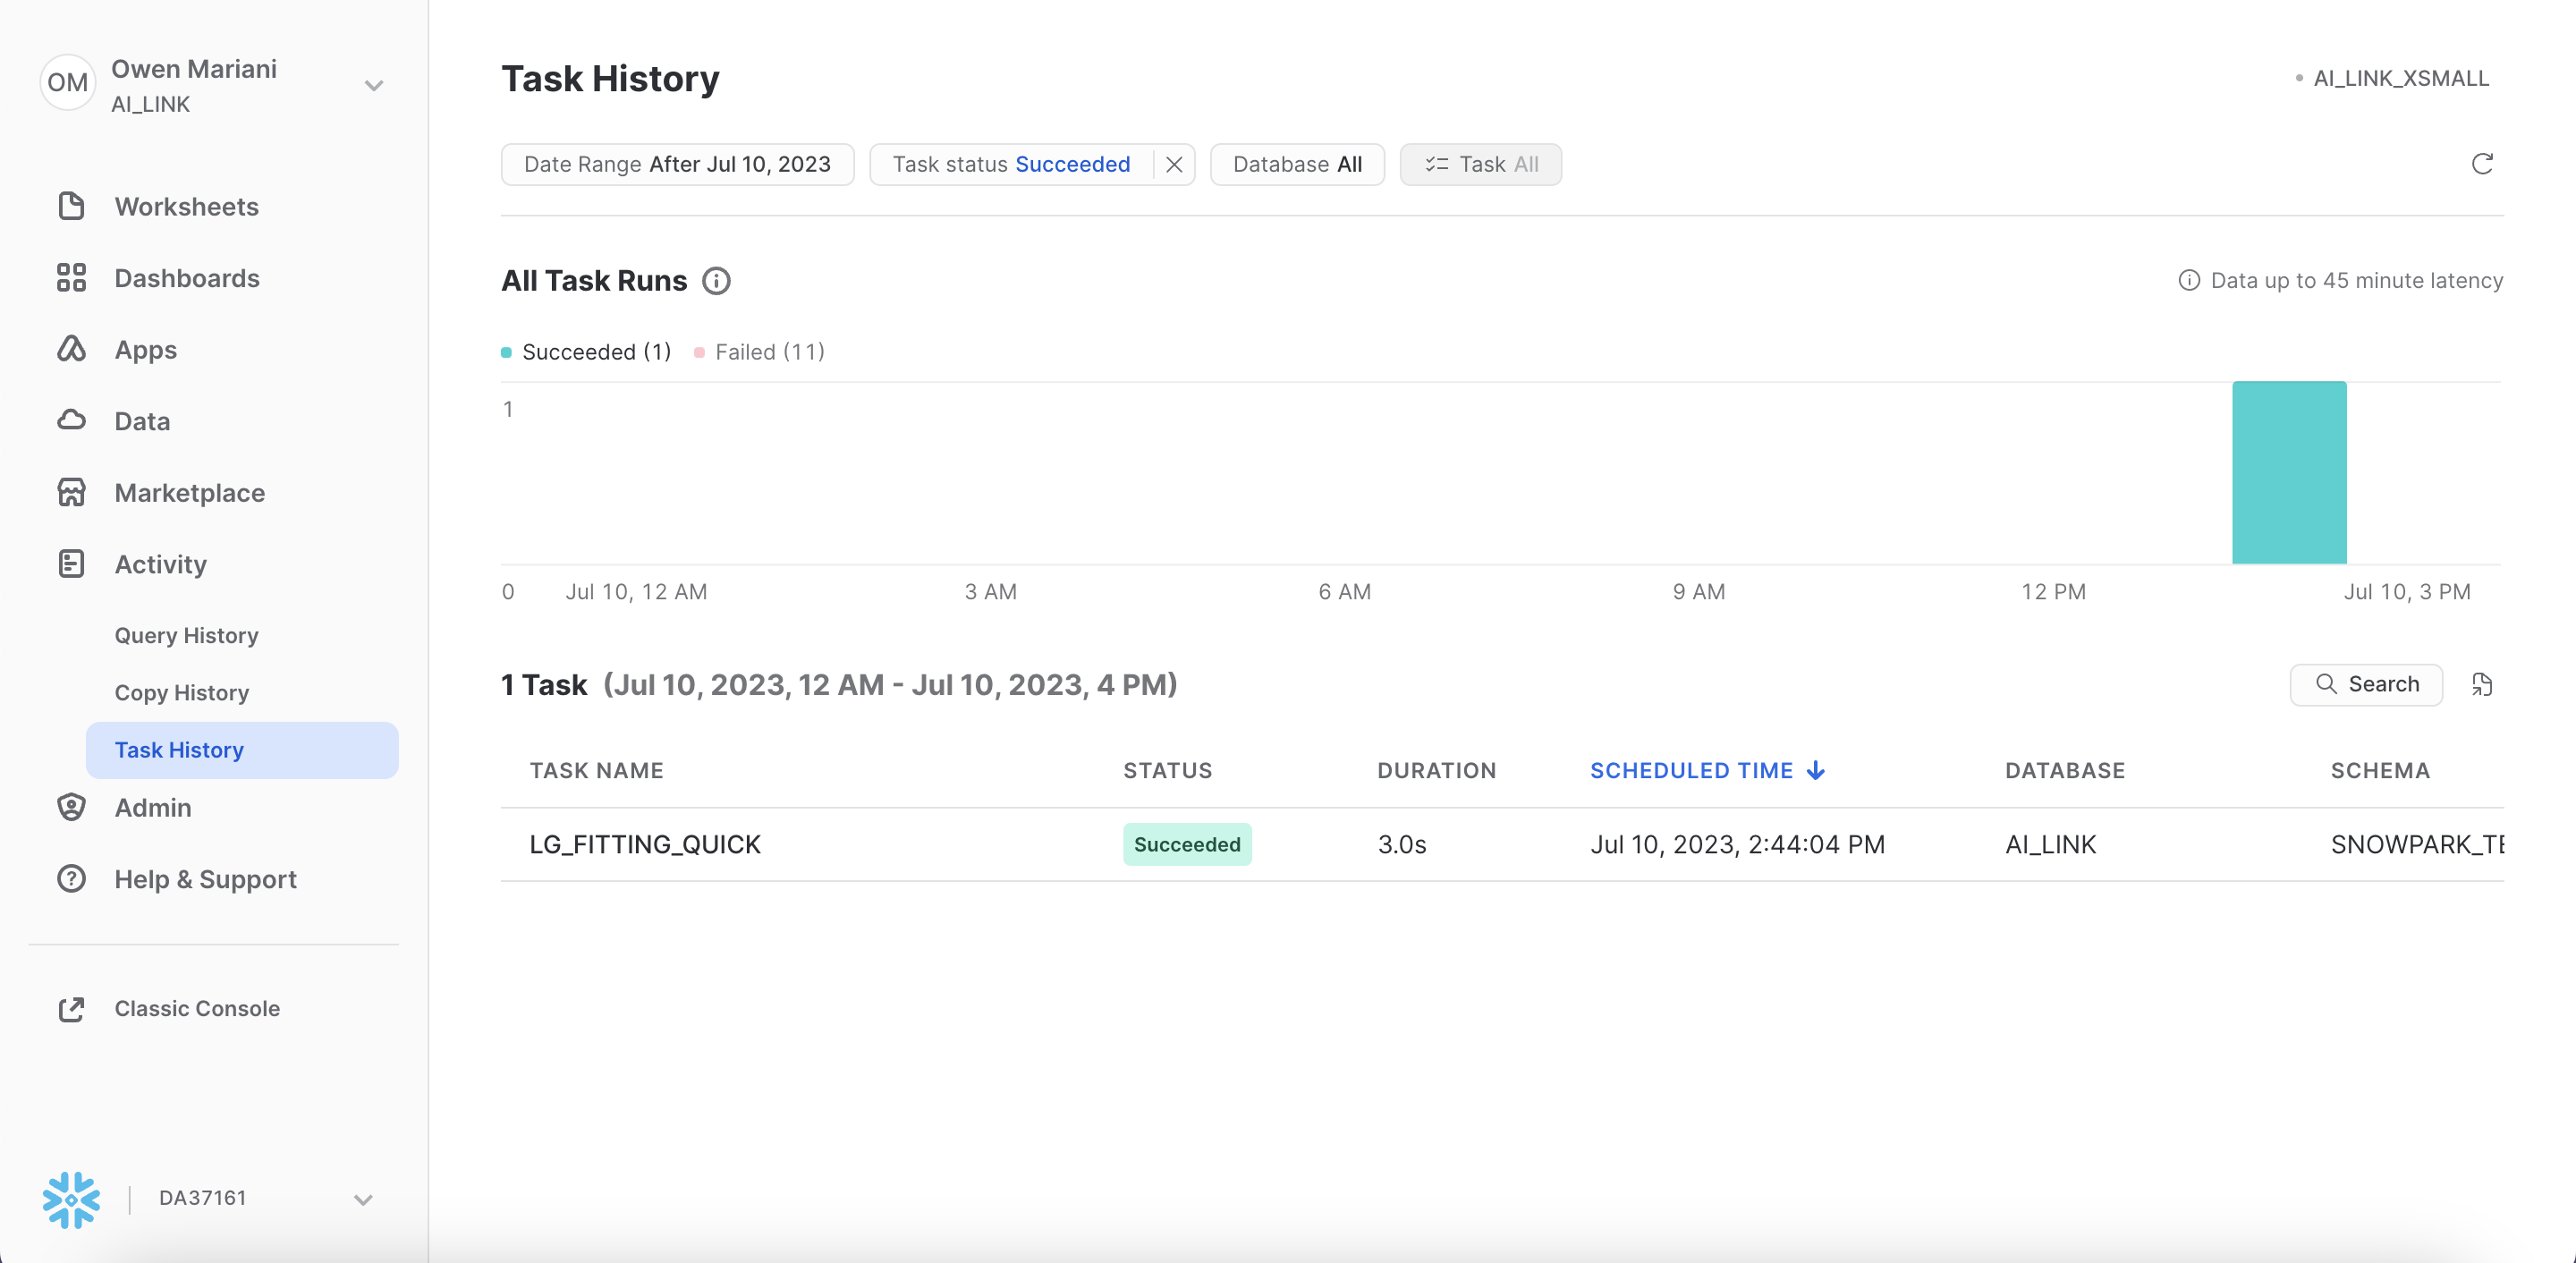
<p style = "text-align: center">In the <b>Activity</b> tab you can check the progress of tasks</p>

In [ ]:
session.close()

<h1>Summary</h1>
<p>With almost entirely Python, we were able to</p> 
<ul><li><b>Access data</b> from AtScale's Semantic Layer</li> 
    <li><b>Define our own function</b> in Snowflake</li>  
    <li><b>Schedule machine learning processes</b> with Snowpark</li><ul> 
    <br>

<p style = "text-align: center;"><font color = "" size = "3px;">With AI-Link streamlining the data exploration and table creation steps, users are able to take full advantage of tools like Snowpark without having to overcome a typically difficult start up. <b>Together, AI-Link and Snowpark make insights through machine learning accessible and shorten the time to insights and value.</b></font></p

<div>
    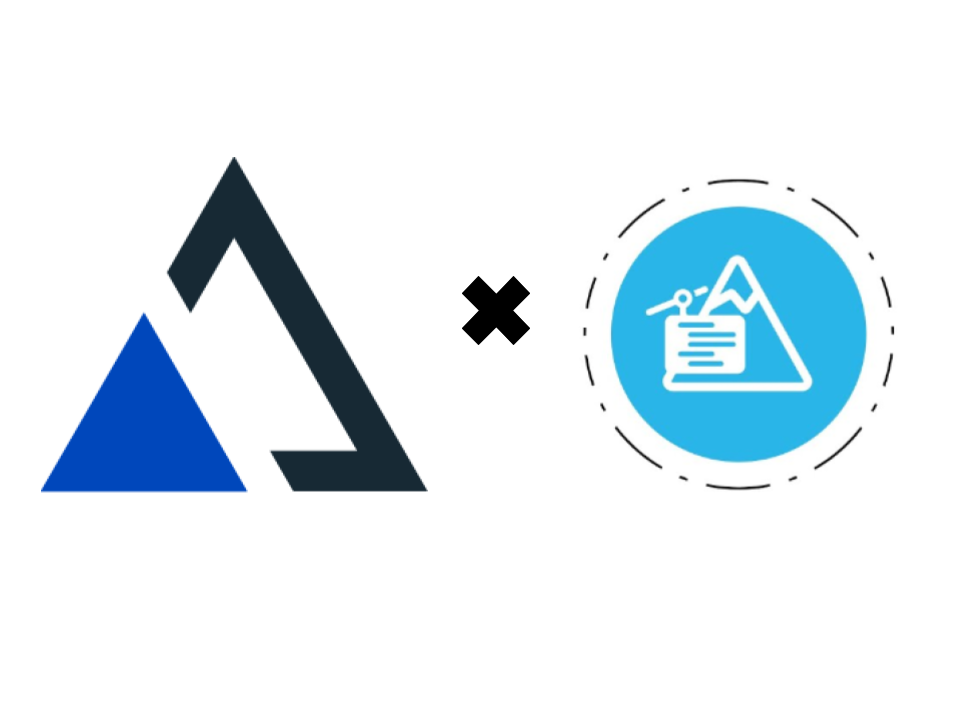
</div>